In this note, I extend a [previous post](http://rlhick.people.wm.edu/posts/comparing-the-speed-of-matlab-versus-pythonnumpy.html) on comparing run-time speeds of various econometrics packages by

1. Adding Stata to the original comparison of Matlab and Python
2. Calculating runtime speeds by
    * Comparing full OLS estimation functions for each package
        - Stata: `reg`
        - Matlab: `fitlm`
        - Python: `regression.linear_model.OLS` from the `statsmodels` module.
    * Comparing the runtimes for calculations using linear algebra code for the OLS model: \\( (x'x)^{-1}x'y \\)     
3. Since Stata and Matlab automatically parralelize some calculations, we parallelize the python code using the `Parallel` module.
<!--TEASER_END-->


In addition to the above, I attempted to do some optimization using the Numba python module, that has been [shown to yield remarkable speedups](http://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/), but saw no performance improvements for my code. 


The computational problem considered here is a fairly large bootstrap of a simple OLS model and is described in detail in the [previous post](http://rlhick.people.wm.edu/posts/comparing-the-speed-of-matlab-versus-pythonnumpy.html).

**tl;dr**


Time consuming econometric problems are best performed in Python or Matlab.  Based on this comparison, Stata is dramatically slower (particularly when Parallel processing in either Python or Matlab).


Matlab is the fastest platform when code avoids the use of certain Matlab functions (like `fitlm`).  While slower, Python compares favorably to Matlab, particularly with the ability to use more than 12 processing cores when running jobs in parallel.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as sm
from timeit import timeit
from numba import double
from numba.decorators import jit, autojit
from joblib import Parallel, delayed

For boostrapping standard errors, we will consider 1,000 bootstrap replicate draws.  We will explore several sample sizes (\\(n=\begin{bmatrix}1000& 10,000& 100,000\end{bmatrix}\\)) for the underlying dependent and independent variables.   The true parameters are
$$
\beta = \begin{bmatrix} -.5 \\ .5 \\ 10\end{bmatrix}
$$

In [2]:
reps, beta, n_array = 1000, [-.5,.5,10], [1000, 10000, 100000]

# A comparison of Bootstrapping with OLS Functions

The first comparison we will perform uses the following functions:

|  | function|
|:--:|:--:|:---|
|Stata|`reg`|
|Matlab|`fitlm`|
|Python|`regression.linear_model.OLS`|


**What is calculated**

It is important to note several features of these OLS functions.  The Stata `reg` command only calculate robust standard errors by request [need to verify this], whereas `fitlm` and `regression.linear_model.OLS` calculate several variants of robust standard errors, and all other factors equal should run slower due to these additional calculations.


**Multiple Threads and Parallel Processing**

In Stata and Matlab, the `reg` and `fitlm` are automatically multi-threaded without any user intervention.  Consequently, all other factors equal python should run slower as by default `regression.linear_model.OLS` is not multithreaded.  These comments are based on my observing cpu load using the unix `top` command.  Python never extends much beyond 100%, whereas Stata and Matlab extend to the 200% to 300% range.

### First consider the bootstrap in Matlab

In [3]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge
Send 'exit' command to kill the server
....MATLAB started and connected!


In [4]:
%%matlab -i reps,beta,n_array -o mat_time,store_beta

mat_time = zeros(cols(n_array),2);
    
for i=1:cols(n_array)
n=n_array(i);
row_id =1:n;
X = [normrnd(10,4,[n 2]) ones(n,1)];

Y = X*beta' + normrnd(0,1,[n 1]);

    store_beta = zeros(reps,3); 
    tic;
    for r = 1:reps
       this_row = randsample(row_id,n,true);
       est = fitlm(X(this_row,:),Y(this_row),'linear','Intercept',false);
       store_beta(r,:) = (est.Coefficients.Estimate)'; 
    end
    mat_time(i,:) = [n toc];
end

Here are the results for \\(N=100,000\\).

In [5]:
matlab_results = pd.DataFrame(store_beta.copy(),columns=['b1','b2','constant'])
matlab_results.describe(percentiles=[.01,.025,.5,.95,.975,.99])

b1           b2     constant
count  1000.000000  1000.000000  1000.000000
mean     -0.500783     0.499098    10.012360
std       0.000778     0.000803     0.011445
min      -0.503204     0.496346     9.974214
1%       -0.502515     0.497165     9.984511
2.5%     -0.502226     0.497509     9.991038
50%      -0.500783     0.499143    10.012116
95%      -0.499493     0.500333    10.031592
97.5%    -0.499266     0.500623    10.035487
99%      -0.499011     0.500946    10.038212
max      -0.498060     0.501551    10.046288

### The same Bootstrap in Python

Here is the python function implementing each replicate of the bootstrap.  It samples with replacement from the data, calculates the OLS estimates, and saves them in a numpy matrix.

In [6]:
def python_boot(arg_reps,arg_row_id,arg_n,arg_X,arg_Y):
    store_beta = np.zeros((reps,X.shape[1]))
    for r in range(arg_reps):
        this_sample = np.random.choice(arg_row_id, size=arg_n, replace=True) # gives sampled row numbers
        # Define data for this replicate:    
        X_r = arg_X[this_sample,:]
        Y_r = arg_Y[this_sample]
        # Estimate model 
        store_beta[r,:] = sm.regression.linear_model.OLS(Y_r,X_r).fit(disp=0).params
    return store_beta

Matlab employs a just in time compiler to translate code to machine binary executables.  This substantially increases speed and is seemless from the user perspective since since it is performed automatically in the background when a script is run.  The python [Numba Project](http://numba.pydata.org/) has developed a similar just in time compiler, with very minimal addtional coding required.  One only needs to add `@jit` before functions you would like to compile, as shown below:

In [7]:
@jit(nogil=True)
# rewriting python_boot to make function args explicit:
def python_boot_numba(arg_reps,arg_row_id,arg_n,arg_X,arg_Y):
    store_beta = np.zeros((1000,3))
    for r in range(arg_reps):
        this_sample = np.random.choice(arg_row_id, size=arg_n, replace=True) # gives sampled row numbers
        # Define data for this replicate:    
        X_r = arg_X[this_sample,:]
        Y_r = arg_Y[this_sample]
        # Estimate model 
        store_beta[r,:] = sm.regression.linear_model.OLS(Y_r,X_r).fit(disp=0).params
    return store_beta

In [8]:
for n in [1000,10000,100000]:
    row_id = range(0,n)
    X1 = np.random.normal(10,4,(n,1))
    X2 = np.random.normal(10,4,(n,1))
    X=np.append(X1,X2,1)
    X = np.append(X,np.tile(1,(n,1)),1)
    error = np.random.randn(n,1)
    Y = np.dot(X,beta).reshape((n,1)) + error
    print "Number of observations= ",n
    %timeit python_boot(reps,row_id,n,X,Y)
    %timeit python_boot_numba(reps,row_id,n,X,Y)

Number of observations=  1000
1 loops, best of 3: 836 ms per loop
1 loops, best of 3: 841 ms per loop
Number of observations=  10000
1 loops, best of 3: 3.58 s per loop
1 loops, best of 3: 3.56 s per loop
Number of observations=  100000
1 loops, best of 3: 30.7 s per loop
1 loops, best of 3: 32.5 s per loop


The numba speed (the second entry for each value of n) up actually is very small at best, exactly as predicted by the numba project's documentation since we don't have "native" python code (we call numpy functions which can't be compiled in optimal ways).  Also, it looks like run times scale linearly.

Next, is a printout of the results for \\( N=100,000 \\).

In [9]:
store_beta = python_boot(reps,row_id,100000,X,Y)
results = pd.DataFrame(store_beta,columns=['b1','b2','constant'])
results.describe(percentiles=[.01,.025,.5,.95,.975,.99])

b1           b2     constant
count  1000.000000  1000.000000  1000.000000
mean     -0.501051     0.499463    10.015594
std       0.000815     0.000770     0.011765
min      -0.503515     0.496934     9.973254
1%       -0.502901     0.497677     9.987255
2.5%     -0.502635     0.498047     9.991328
50%      -0.501082     0.499447    10.015637
95%      -0.499684     0.500709    10.034549
97.5%    -0.499387     0.501007    10.038958
99%      -0.499134     0.501479    10.042510
max      -0.498420     0.502184    10.048871

### Next we'll perform the same bootstrap in Stata.  

This is run in Stata 12.1 MP (2 cores).  Admittedly, this is a fairly old version of stata, so perhaps newer ones are faster.

```
clear
set more off

*before looping, generate variables so we can use replace in the loops
set obs 10
gen x1 = 0
gen x2 = 0
gen xb = 0
gen error =0
gen y = 0

foreach num of numlist 1000 10000 100000 {
set obs `num'
*generate x's
replace x1 = rnormal(10,4)
replace x2 = rnormal(10,4) 

replace xb = 10 + .5*x1 -.5*x2
replace error = rnormal()

replace y = xb + e

timer clear
timer on 1
quietly bootstrap _b, reps(1000): quietly reg y x1 x2
timer off 1
quietly timer list
di "Time: " r(t1)
}

estat bootstrap, percentile
```

Produced these results

```
obs was 10, now 1000
Time: 3.445
obs was 1000, now 10000
Time: 10.346
obs was 10000, now 100000
Time: 91.113

. 
. estat bootstrap, percentile

Linear regression                               Number of obs      =    100000
                                                Replications       =      1000

------------------------------------------------------------------------------
             |    Observed               Bootstrap
           y |       Coef.       Bias    Std. Err.  [95% Conf. Interval]
-------------+----------------------------------------------------------------
          x1 |   .50049835   4.44e-06   .00081187    .4990234   .5021256   (P)
          x2 |  -.49990621   .0000552    .0008086   -.5013727  -.4982354   (P)
       _cons |   9.9916064  -.0004185   .01208307    9.967021   10.01425   (P)
------------------------------------------------------------------------------
(P)    percentile confidence interval
```


## Discussion

The following chart shows the performance of each statistical package using native OLS functions

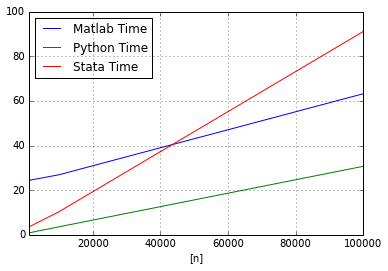

In [10]:
# Convert to pandas dataframe for plotting:
matlab_data=pd.DataFrame(mat_time,columns=['n','Matlab Time'])
python_data=pd.DataFrame([[1000,.836],[10000,3.58],[100000,30.7]],columns=['n','Python Time'])
stata_data=pd.DataFrame([[1000,3.445],[10000,10.346],[100000,91.113]],columns=['n','Stata Time'])
plot_data = pd.concat([matlab_data,python_data['Python Time'],stata_data['Stata Time']], axis=1)
#plot_data = plot_data.set_index('n')
plot_data.plot(x=['n'],y=['Matlab Time','Python Time','Stata Time'])

Having run the bootstrap for \\(n = \begin{bmatrix}1,000 & 10,000 & 100,000 \end{bmatrix}\\), we see that 

1. Python outperforms Matlab and Stata for any sample size.
2. As the sample size increases, the gap between python and matlab is constant, whereas for larger \\(n\\), Stata's performance relative to either package deteriorates rapidly.


Because we are relying on the "canned" OLS functions, the comparison above may be capturing the relative inefficiency of these functions rather than the underlying speed of the statistical platform.  

# A comparison of Bootstrapping (no functions)

We will perform the exact same analysis as before with slight modifications to the functions for calculating the OLS estimates using linear algebra code for each package (\\((x'x)^{-1}x'y\\)).  For the sake of brevity, I won't show results, but instead just focus on runtimes.

The Matlab code is:

In [11]:
%%matlab -i reps,beta,n_array -o mat_time_la,store_beta

mat_time_la = zeros(cols(n_array),2);
    
for i=1:cols(n_array)
n=n_array(i);
row_id =1:n;

X = [normrnd(10,4,[n 2]) ones(n,1)];

Y = X*beta' + normrnd(0,1,[n 1]);

    store_beta = zeros(reps,3); 
    tic;
    for r = 1:reps
       this_row = randsample(row_id,n,true);
       store_beta(r,:) = (inv(X(this_row,:)'*X(this_row,:))*X(this_row,:)'*Y(this_row))'; 
    end
    mat_time_la(i,:) = [n toc];
end

The python code is:

In [12]:
def python_boot_la(arg_reps,arg_row_id,arg_n,arg_X,arg_Y):
    store_beta = np.zeros((reps,X.shape[1]))
    for r in range(arg_reps):
        this_sample = np.random.choice(arg_row_id, size=arg_n, replace=True) # gives sampled row numbers
        # Define data for this replicate:    
        X_r = arg_X[this_sample,:]
        Y_r = arg_Y[this_sample]
        # Estimate model 
        store_beta[r,:] = (np.linalg.inv(np.dot(X_r.T,X_r)).dot(np.dot(X_r.T,Y_r))).T
    return store_beta

for n in [1000,10000,100000]:
    row_id = range(0,n)
    X1 = np.random.normal(10,4,(n,1))
    X2 = np.random.normal(10,4,(n,1))
    X=np.append(X1,X2,1)
    X = np.append(X,np.tile(1,(n,1)),1)
    error = np.random.randn(n,1)
    Y = np.dot(X,beta).reshape((n,1)) + error
    print "Number of observations= ",n
    %timeit python_boot_la(reps,row_id,n,X,Y)

Number of observations=  1000
1 loops, best of 3: 309 ms per loop
Number of observations=  10000
1 loops, best of 3: 2.12 s per loop
Number of observations=  100000
1 loops, best of 3: 21.7 s per loop


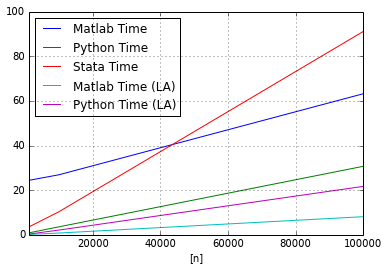

In [13]:
# add results for plotting:
# Convert to pandas dataframe for plotting:
matlab_la_data=pd.DataFrame(mat_time_la,columns=['n','Matlab Time (LA)'])
python_la_data=pd.DataFrame([[1000,.309],[10000,2.12],[100000,21.7]],columns=['n','Python Time (LA)'])
plot_data_2 = pd.concat([plot_data,python_la_data['Python Time (LA)'],matlab_la_data['Matlab Time (LA)']], axis=1)
#plot_data = plot_data.set_index('n')
plot_data_2.plot(x=['n'],y=['Matlab Time','Python Time','Stata Time','Matlab Time (LA)','Python Time (LA)'])

### Discussion

The linear algebra model run times for both Python and Matlab are denoted by LA.  We add them to the previous figure.


The python results are very similar, showing that the statsmodels OLS function is highly optimized.  On the other hand, Matlab shows significant speed improvements and demonstrates how native linear algebra code is preferred for speed.  For this example, Matlab is roughly three times faster than python.


Stata was dropped from the comparison because of lack of support in Stata's linear algebra environment (Mata) for sampling with replacement for large \\(N\\).

## Parallelizing the Bootstrap

All of the results above are run using default settings with respect to multi-threading or using multiple processing cores.  Matlab and Stata automatically take advantage of multiple cores, whereas Python doesn't.  The following comparison manually creates worker pools in both Matlab and Python.  The current version of Matlab requires the license for the Parallel Computing Toolbox that [supports 12 workers](http://www.mathworks.com/help/distcomp/parpool.html) and to get more, one would need to purchase and configure the Matlab Distributed Computer Server and the price is conditional on the number of nodes (or roughly speaking, cores) one wants to use.  To get any multi-core support in Stata, you must purchase the MP version of the program.


Here is the Matlab code starting a worker pool and running the bootstrap code:

In [14]:
%%matlab -i reps,beta,n_array -o mat_time_la_par,store_beta

if isempty(gcp('nocreate'))
parpool;
end

mat_time_la_par = zeros(cols(n_array),2);
    
for i=1:3
n=n_array(i);
row_id = 1:n;
X = [normrnd(10,4,[n 2]) ones(n,1)];

Y = X*beta' + normrnd(0,1,[n 1]);

    store_beta = zeros(reps,3); 
    tic
    parfor r = 1:reps
       this_row = randsample(row_id,n,true);
       store_beta(r,:) = (ols(Y(this_row),X(this_row,:)))'; 
    end
    mat_time_la_par(i,:) = [n toc];
end

delete(gcp('nocreate'));

Starting parallel pool (parpool) using the 'local' profile ... connected to 12 workers.
Parallel pool using the 'local' profile is shutting down.


The following runs the bootstrap in parallel in Python.  Note, when passing the n_jobs parameter to the Parallel procedure, one is not arbitrarily restricted due to licensing limits.

In [15]:
def python_boot_parallel(arg_reps):
    np.random.seed(arg_reps)
    this_sample = np.random.choice(row_id, size=n, replace=True) # gives sampled row numbers
    # Define data for this replicate:    
    X_r = X[this_sample,:]
    Y_r = Y[this_sample]
    # Estimate model 
    beta = (np.linalg.inv(np.dot(X_r.T,X_r)).dot(np.dot(X_r.T,Y_r))).T
    return beta

for n in [1000,10000,100000]:
    row_id = range(0,n)
    X1 = np.random.normal(10,4,(n,1))
    X2 = np.random.normal(10,4,(n,1))
    X=np.append(X1,X2,1)
    X = np.append(X,np.tile(1,(n,1)),1)
    error = np.random.randn(n,1)
    Y = np.dot(X,beta).reshape((n,1)) + error
    print n
    %timeit Parallel(n_jobs=10)(delayed(python_boot_parallel) (arg_reps) for arg_reps in range(reps))
    %timeit Parallel(n_jobs=20)(delayed(python_boot_parallel) (arg_reps) for arg_reps in range(reps))
    %timeit Parallel(n_jobs=25)(delayed(python_boot_parallel) (arg_reps) for arg_reps in range(reps))

1000
1 loops, best of 3: 409 ms per loop
1 loops, best of 3: 429 ms per loop
1 loops, best of 3: 445 ms per loop
10000
1 loops, best of 3: 488 ms per loop
1 loops, best of 3: 531 ms per loop
1 loops, best of 3: 469 ms per loop
100000
1 loops, best of 3: 2.91 s per loop
1 loops, best of 3: 1.92 s per loop
1 loops, best of 3: 1.95 s per loop


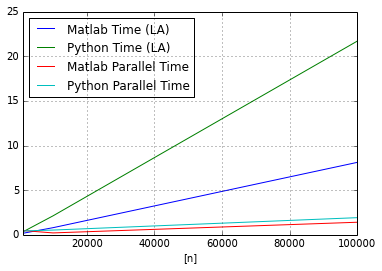

In [16]:
# use n_jobs=20
python_para_data=pd.DataFrame([[1000,.429],[10000,.531],[100000,1.92]],columns=['n','Python Parallel Time'])
matlab_para_data=pd.DataFrame(mat_time_la_par,columns=['n','Matlab Parallel Time'])

plot_data_3 = pd.concat([plot_data_2,python_para_data['Python Parallel Time'],matlab_para_data['Matlab Parallel Time']], axis=1)
plot_data_3.plot(x=['n'],y=['Matlab Time (LA)','Python Time (LA)','Matlab Parallel Time','Python Parallel Time'])

**Discussion**

Both Matlab and Python show dramatic improvements when bootstrap replicates are distributed across multiple processor cores.  While Matlab is the fastest for this example, Python's parallel performance is impressive.  In terms of percentage gains, Python shows the largest percentage improvements in run times when the linear algebra code is distributed over multiple processors.  


It is notable that Matlab's Parallel Toolbox is limited to 12 workers, whereas in Python there is no limit to the number of workers.


The full table of results is shown below.

In [17]:
plot_data_3.head()

n  Matlab Time  Python Time  Stata Time  Python Time (LA)  \
0    1000    24.366323        0.836       3.445             0.309   
1   10000    26.902861        3.580      10.346             2.120   
2  100000    63.204921       30.700      91.113            21.700   

   Matlab Time (LA)  Python Parallel Time  Matlab Parallel Time  
0          0.163328                 0.429              0.479305  
1          0.796194                 0.531              0.211717  
2          8.114325                 1.920              1.406549

Detailed info on machine this was run on:

```
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                28
On-line CPU(s) list:   0-27
Thread(s) per core:    2
Core(s) per socket:    14
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Model name:            Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz
Stepping:              2
CPU MHz:               1201.281
CPU max MHz:           3600.0000
CPU min MHz:           1200.0000
BogoMIPS:              5187.74
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              35840K
NUMA node0 CPU(s):     0-27
```